In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 2s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


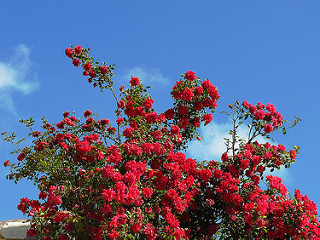

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

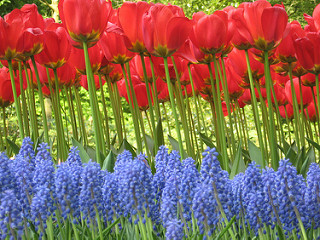

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

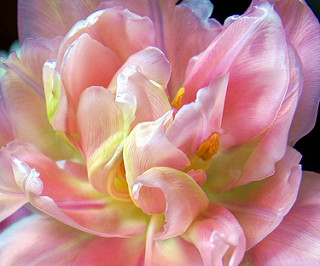

In [6]:
PIL.Image.open(str(tulips[1]))

creating data

In [7]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


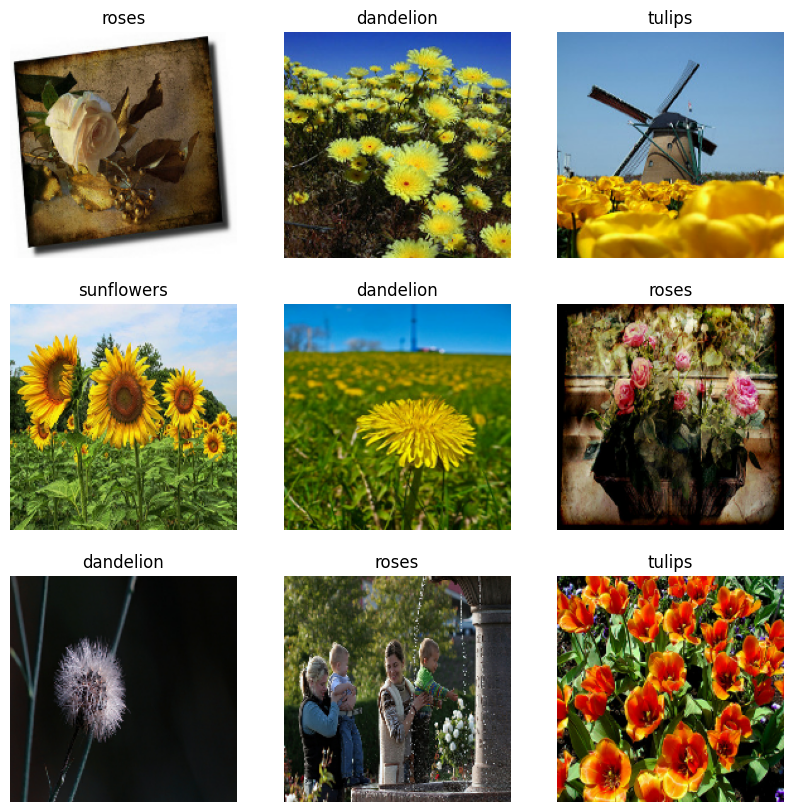

In [11]:
#visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Configure the dataset for performance
Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
#There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Create the model
The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [15]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
For this tutorial, choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
#Model summary
#View all the layers of the network using the Keras Model.summary method:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model
Train the model for 10 epochs with the Keras Model.fit method:

In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 118s 1s/step - loss: 1.5459 - accuracy: 0.3583 - val_loss: 1.3156 - val_accuracy: 0.4578
Epoch 2/10
92/92 [==============================] - 110s 1s/step - loss: 1.1137 - accuracy: 0.5749 - val_loss: 1.0494 - val_accuracy: 0.5995
Epoch 3/10
92/92 [==============================] - 108s 1s/step - loss: 0.9134 - accuracy: 0.6437 - val_loss: 0.9654 - val_accuracy: 0.6471
Epoch 4/10
92/92 [==============================] - 105s 1s/step - loss: 0.7381 - accuracy: 0.7268 - val_loss: 0.9858 - val_accuracy: 0.6158
Epoch 5/10
92/92 [==============================] - 110s 1s/step - loss: 0.5654 - accuracy: 0.7956 - val_loss: 1.2667 - val_accuracy: 0.6063
Epoch 6/10
92/92 [==============================] - 107s 1s/step - loss: 0.3828 - accuracy: 0.8665 - val_loss: 1.2573 - val_accuracy: 0.6335
Epoch 7/10
92/92 [==============================] - 110s 1s/step - loss: 0.2461 - accuracy: 0.9125 - val_loss: 1.3798 - val_accuracy: 0.6172
Epoch 8/10
92

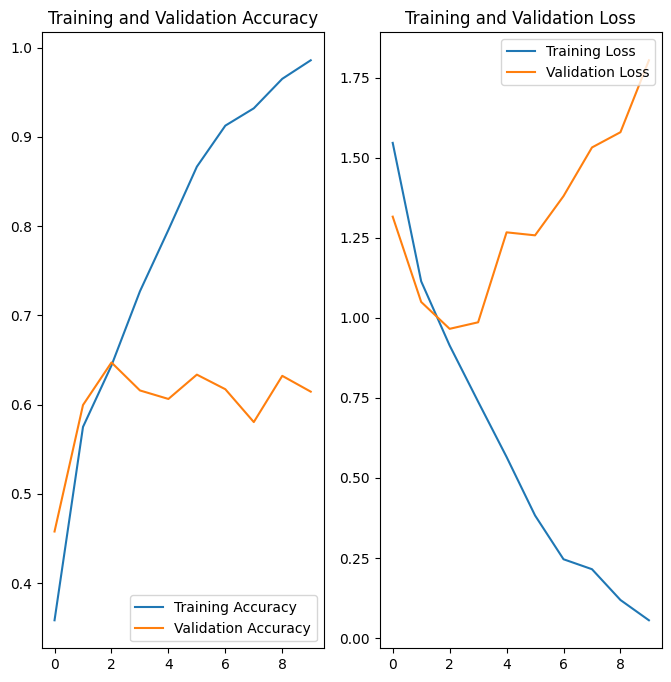

In [19]:
#Visualize training results
#Create plots of the loss and accuracy on the training and validation sets:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Overfitting
In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add dropout to your model.

### Data augmentation
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. These can be included inside your model like other layers, and run on the GPU.

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

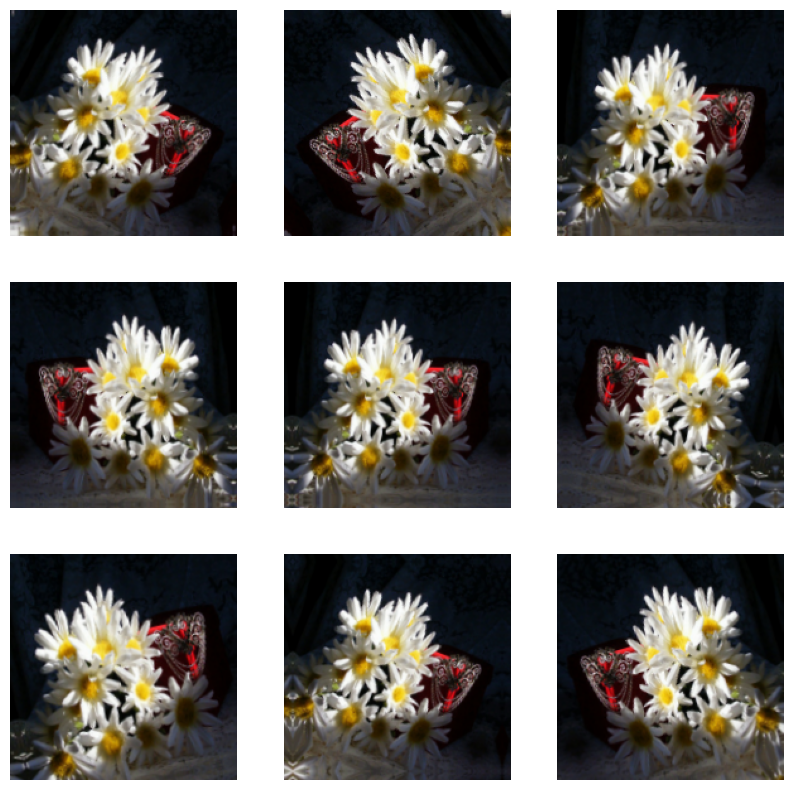

In [21]:
# Visualize a few augmented examples by applying data augmentation to the same image several times:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

###Dropout
Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [22]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [23]:
# compile and train model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [25]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 126s 1s/step - loss: 1.2974 - accuracy: 0.4394 - val_loss: 1.0369 - val_accuracy: 0.5858
Epoch 2/15
92/92 [==============================] - 124s 1s/step - loss: 1.0337 - accuracy: 0.5933 - val_loss: 0.9744 - val_accuracy: 0.6213
Epoch 3/15
92/92 [==============================] - 126s 1s/step - loss: 0.9327 - accuracy: 0.6386 - val_loss: 0.9421 - val_accuracy: 0.6158
Epoch 4/15
92/92 [==============================] - 127s 1s/step - loss: 0.8527 - accuracy: 0.6795 - val_loss: 0.8537 - val_accuracy: 0.6540
Epoch 5/15
92/92 [==============================] - 125s 1s/step - loss: 0.8110 - accuracy: 0.6931 - val_loss: 0.8355 - val_accuracy: 0.6676
Epoch 6/15
92/92 [==============================] - 128s 1s/step - loss: 0.7605 - accuracy: 0.7061 - val_loss: 0.8268 - val_accuracy: 0.6798
Epoch 7/15
92/92 [==============================] - 126s 1s/step - loss: 0.7364 - accuracy: 0.7214 - val_loss: 0.8077 - val_accuracy: 0.6785
Epoch 8/15
92

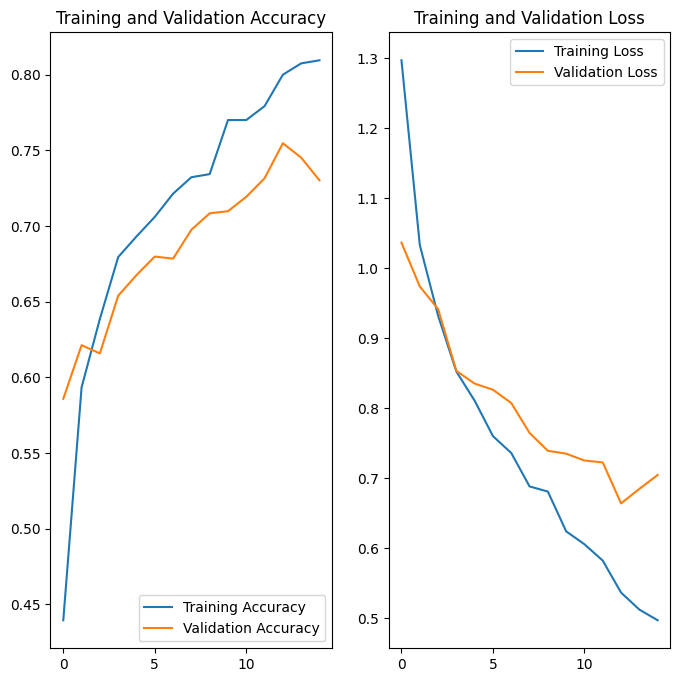

In [26]:
# After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()